# Descarga de tweets
Se instalan las librerías necesarias

In [ ]:
#!pip install tweepy


In [ ]:
%%capture
import tweepy as tw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
import collections
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
#NLP
import re
import string
from string import digits
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
import itertools
#Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [ ]:

def tokenization(text):
    text = word_tokenize(text.lower())
    return text


Las claves vienen desde Tweeter developer app

In [ ]:
consumer_key= 
consumer_secret= 
access_token= 
access_token_secret= 

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
palabras = "Aragón OR Aragon OR Zaragoza OR zaragoza OR Teruel OR teruel OR Huesca OR huesca OR heraldo OR heraldoes OR zaragozano or turolense or oscense or Zaragozano or Turolense or Oscense"

In [ ]:
#https://medium.com/@robguilarr/making-queries-to-twitter-api-on-tweepy-66afeb7184a4

Filtramos palabras relacionadas con Aragón y eliminamos los retweets

In [ ]:
# Define the search term and the date_since date as variables
search_words = palabras + " -filter:retweets"
date_since = "2008-11-16"


In [ ]:
# Collect tweets
lista = []
geo = []
fecha = []
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="es",
              since=date_since).items(2000)

# Iterate and print tweets
for tweet in tweets:
  lista.append(tweet.text)
  geo.append(tweet.user.location)
  fecha.append(tweet.user.created_at)

Se crea un dataframe que incluye la fecha y la geolocalización. Este última no es muy precisa

In [ ]:
df1 = pd.DataFrame(lista, columns = ["Texto_tweet"])
df2 = pd.DataFrame(geo, columns = ["Geo"])
df3 = pd.DataFrame(fecha, columns = ["Fecha"])
df4 = pd.concat((df1, df2, df3), axis = 1).drop_duplicates().reset_index(drop = True)
df4

Texto_tweet  ...               Fecha
0     @Almudena_Sopena Se han lucrado del Zaragoza d...  ... 2019-07-28 01:06:51
1                                  @lal_aragon Buenos!!  ... 2010-10-15 07:58:58
2     @mendezLopezg1 Cómo agua.... T___T)) ya sabía ...  ... 2010-11-18 04:40:57
3     @J_Zaragoza_ No cómo hizo el psoe en Andalucía...  ... 2020-05-01 21:07:21
4     @Diablo_Heraldo @Cruyffero No me convence tamp...  ... 2020-07-26 00:05:33
...                                                 ...  ...                 ...
1995  Personal Laboral AGE: CONFLICTO COLECTIVO POR ...  ... 2014-05-27 05:58:33
1996              @J_Zaragoza_ Tan bien como al peeseoe  ... 2016-03-24 18:58:34
1997  @vlc_JI @BEsquiliche @sabina66801497 @POZI1972...  ... 2015-03-23 18:40:15
1998  @MBlanquillo1932 @CopeZaragoza Eso si, cualqui...  ... 2010-06-20 18:17:24
1999  @sabina66801497 @POZI1972 @DanielRodOrd @Ctzen...  ... 2021-08-13 21:54:23

[2000 rows x 3 columns]

Exporto el dataframe para el valorador automático

In [ ]:
import os
os.chdir("/content/drive/MyDrive/HaPyness")
df4.to_csv("para_valorar_Fernando.csv")

In [ ]:
import os
os.chdir("/content/drive/MyDrive/HaPyness")

Yo también lo cargo para no tener que repetir el descargado de tweets que es un proceso lento.

In [ ]:
df4 = pd.read_csv("para_valorar_Fernando.csv")
df4 = df4.drop("Unnamed: 0", 1)
df4.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Texto_tweet  ...                Fecha
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...  2019-07-28 01:06:51
1                               @lal_aragon Buenos!!  ...  2010-10-15 07:58:58
2  @mendezLopezg1 Cómo agua.... T___T)) ya sabía ...  ...  2010-11-18 04:40:57
3  @J_Zaragoza_ No cómo hizo el psoe en Andalucía...  ...  2020-05-01 21:07:21
4  @Diablo_Heraldo @Cruyffero No me convence tamp...  ...  2020-07-26 00:05:33

[5 rows x 3 columns]

Los tweets se limpian como en el resto de bases de datos usadas

In [ ]:
def transform(text):
  stopwords = nltk.corpus.stopwords.words('spanish')
  stopwords.extend(["El", "Él", "el", "la", "los", "La", "Los", 
                  "hashtag", "si", "sí", "Sí", "dtype", "Index", "length", 
                  "object", "user", "...", "..", "¡", '``', "_", "°C", '___', "___…"])
  text = str(text.lower())
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Remover menciones @
  text = re.sub(r'RT[|\s]', ' ', text) # Remover RTs
  text = re.sub(r'#', ' ', text) #Remover # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links

  #Nuevas incluidas remove links
  text = re.sub(r'http\S+', ' ', text) # remove http links
  text = re.sub(r'bit.ly/\S+', ' ', text) # remove http links
  text = re.sub(r'pic.twitter\S+', ' ', text) # remove links
  text = text.strip('[link]') # remove links

  #Remove hashtags """Takes a string and removes any hash tags"""
  text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove hash tags
  text = re.sub('HASHTAG', '', text)  # remove hash tags)
  text = re.sub('USER', '', text)  # remove hash tags)


  pattern = r'''(?x)                    # set flag to allow verbose regexps
              (?:[A-Z]\.)+            # abbreviations, e.g. U.S.A
              | \w+(?:-\w+)*          # Words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82%
              | \.\.\.                # Ellipsis
              | [][.,;"'?():-_`]      #These are separate tokens; includes ],[
              '''
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # Remover signos de puntuacion
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if  w.lower() not in stopwords] # Remover stopwords

  return (" ".join(no_garbage))

In [ ]:
df4["Tweet_clean"] = df4['Texto_tweet'].apply(transform)
df4["Lista"] = df4['Tweet_clean'].apply(tokenization)
df4

Texto_tweet  ...                                              Lista
0     @Almudena_Sopena Se han lucrado del Zaragoza d...  ...  [sopena, lucrado, zaragoza, primer, minuto, av...
1                                  @lal_aragon Buenos!!  ...                                   [aragon, buenos]
2     @mendezLopezg1 Cómo agua.... T___T)) ya sabía ...  ...  [cómo, agua, tt, sabía, pasaba, aquí, viendo, ...
3     @J_Zaragoza_ No cómo hizo el psoe en Andalucía...  ...            [zaragoza, cómo, hizo, psoe, andalucía]
4     @Diablo_Heraldo @Cruyffero No me convence tamp...  ...      [heraldo, convence, tampoco, mejor, mingueza]
...                                                 ...  ...                                                ...
1995  Personal Laboral AGE: CONFLICTO COLECTIVO POR ...  ...  [personal, laboral, age, conflicto, colectivo,...
1996              @J_Zaragoza_ Tan bien como al peeseoe  ...                     [zaragoza, tan, bien, peeseoe]
1997  @vlc_JI @BEsquiliche @sabina66801497 @POZI1972...  ...                                 [ji, lustre, saez]
1998  @MBlanquillo1932 @CopeZaragoza Eso si, cualqui...  ...  [cualquier, tipo, amenaza, insulto, totalmente...
1999  @sabina66801497 @POZI1972 @DanielRodOrd @Ctzen...  ...                                 [ji, lustre, saez]

[2000 rows x 5 columns]

In [ ]:
nlp = df4.copy()
nlp

Texto_tweet  ...                                              Lista
0     @Almudena_Sopena Se han lucrado del Zaragoza d...  ...  [sopena, lucrado, zaragoza, primer, minuto, av...
1                                  @lal_aragon Buenos!!  ...                                   [aragon, buenos]
2     @mendezLopezg1 Cómo agua.... T___T)) ya sabía ...  ...  [cómo, agua, tt, sabía, pasaba, aquí, viendo, ...
3     @J_Zaragoza_ No cómo hizo el psoe en Andalucía...  ...            [zaragoza, cómo, hizo, psoe, andalucía]
4     @Diablo_Heraldo @Cruyffero No me convence tamp...  ...      [heraldo, convence, tampoco, mejor, mingueza]
...                                                 ...  ...                                                ...
1995  Personal Laboral AGE: CONFLICTO COLECTIVO POR ...  ...  [personal, laboral, age, conflicto, colectivo,...
1996              @J_Zaragoza_ Tan bien como al peeseoe  ...                     [zaragoza, tan, bien, peeseoe]
1997  @vlc_JI @BEsquiliche @sabina66801497 @POZI1972...  ...                                 [ji, lustre, saez]
1998  @MBlanquillo1932 @CopeZaragoza Eso si, cualqui...  ...  [cualquier, tipo, amenaza, insulto, totalmente...
1999  @sabina66801497 @POZI1972 @DanielRodOrd @Ctzen...  ...                                 [ji, lustre, saez]

[2000 rows x 5 columns]

Con la función explode creamos un dataframe en el qcada palabra de la lista es una fila. De este modo se puede contar mucho mejor

In [ ]:
nlp2 = nlp.explode("Lista")
nlp2.head(5)

Texto_tweet  ...     Lista
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...    sopena
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...   lucrado
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...  zaragoza
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...    primer
0  @Almudena_Sopena Se han lucrado del Zaragoza d...  ...    minuto

[5 rows x 5 columns]

In [ ]:
words = list(itertools.chain(nlp2['Lista']))
wf = collections.Counter(words)
wf.most_common(20)


[('zaragoza', 475),
 ('ji', 258),
 ('lustre', 248),
 ('aragón', 189),
 ('heraldo', 161),
 ('teruel', 99),
 ('huesca', 75),
 ('aragon', 67),
 ('morq', 59),
 ('saez', 57),
 ('22', 53),
 ('q', 47),
 ('años', 40),
 ('hoy', 37),
 ('ser', 35),
 ('psoe', 31),
 ('real', 31),
 ('angélica', 30),
 ('ahora', 29),
 ('existe', 28)]

In [ ]:
words = ' '.join(nlp['Tweet_clean'])
words

'sopena lucrado zaragoza primer minuto avalistas  intereses préstam aragon buenos cómo agua   tt   sabía pasaba aquí viendo hechen   angélica ara zaragoza cómo hizo psoe andalucía heraldo convence tampoco mejor mingueza   obra gracia michel bachelet  heraldo muñoz aragon buenos días cielo  voy  feliz día salud mañana cabinas tamizaje covid19 llegarán municipios ilopango  zaragoza  coatepeque victo video completo  zaragoza así demócratas so memes zgz decir  lista ingredientes  recao  viene significar nombre  ojos  depositado lavado lágrimas recuerdo angélica aragón miradademujer ruta silencio  bajo teruel  teruel sos parte historia marcio  informativocaleño informa avioneta sufrió altercado pista aeropuerto alfonso bonilla aragón palm cañaveraldepasiones error telenovelas favoritas  tal gozar angélica aragón  pues memes zgz aquí vídeo cocinero binéfar grabó pandemia ofertas trabajo senior frontend developer aragón  informática bages  españa contrato indefinido jornada completa ofertas t

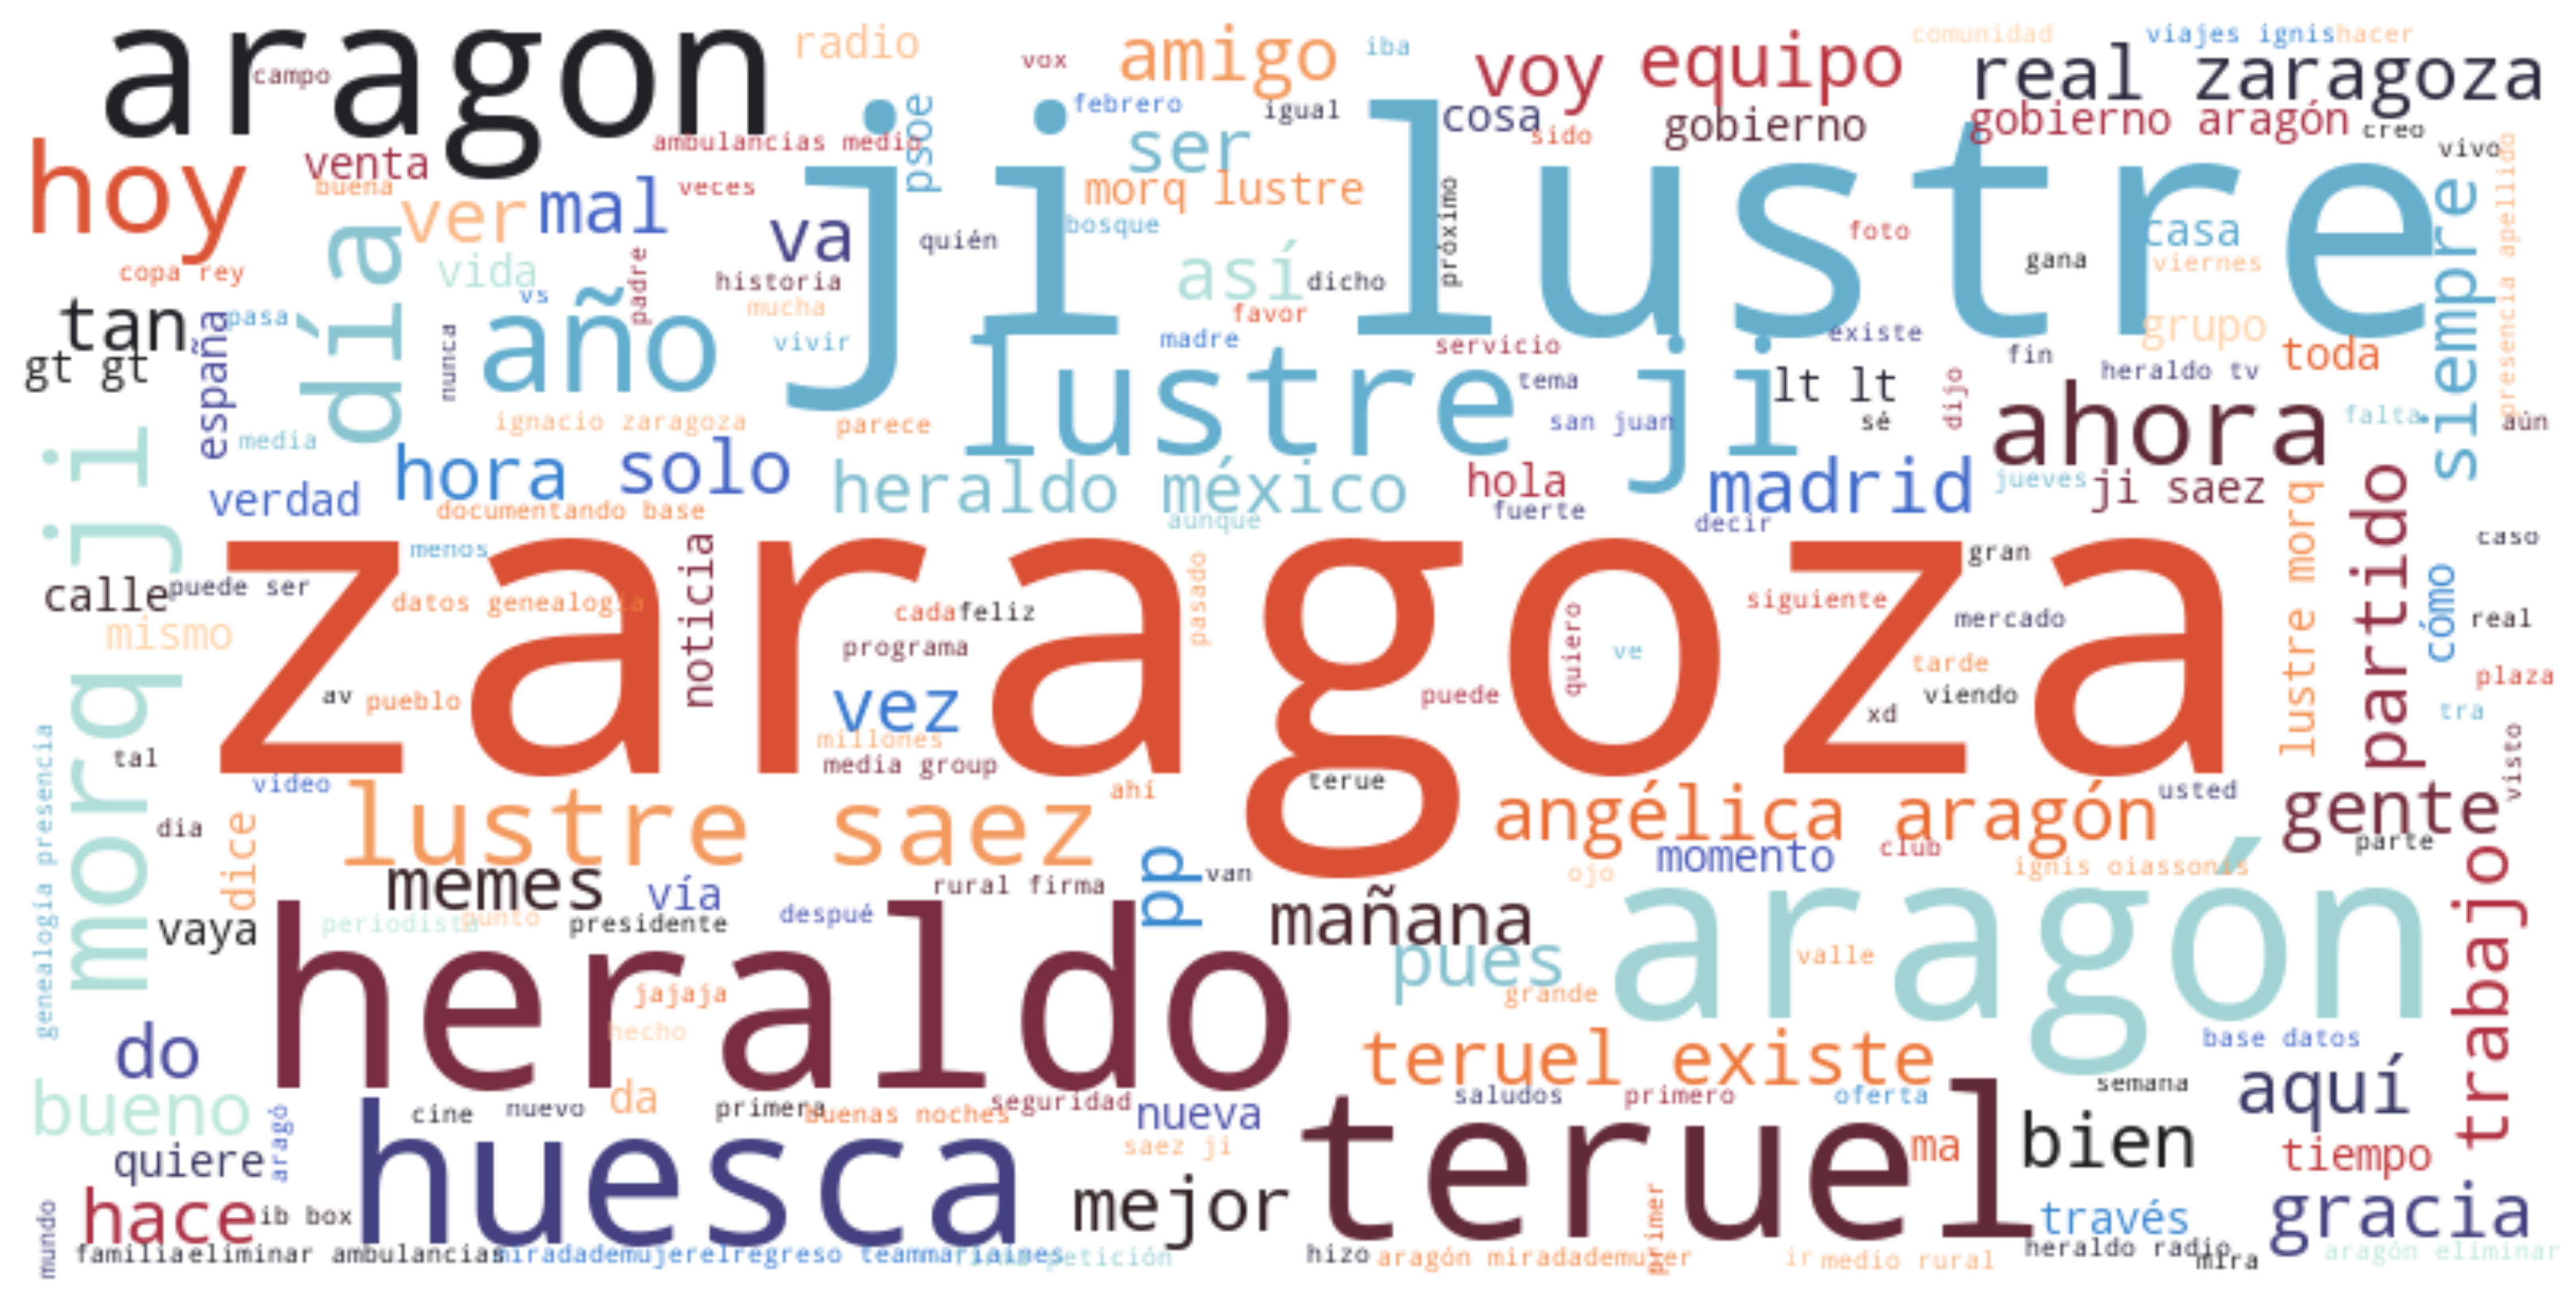

In [ ]:
wordcloud = WordCloud(background_color="white", 
                      stopwords = stopwords,colormap = "icefire", 
                      scale = 2).generate(words)
# Display the generated image:
plt.figure(figsize = (15, 15), dpi = 300, facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

La columna de geolocalización no es muy homogenea, por lo que no realizamos ningún tratamiento.


In [ ]:
nlp['Geo'].value_counts()

Zaragoza, España                  68
España                            64
Costa de la Luz  gaditana         56
Zaragoza                          55
Valencia y ole!!!                 47
                                  ..
Zaragoza, españa                   1
Miguel Hidalgo                     1
Veracruz de Ignacio de la Llav     1
Huelva, España                     1
JAEN                               1
Name: Geo, Length: 508, dtype: int64

In [ ]:
pre_covid = '2019-03-10'
despues = '2019-03-10'
pre = df4[df4['Fecha']<pre_covid]
pre["Covid"] = "PreCovid"
cov = df4[df4['Fecha']>pre_covid]
cov["Covid"] = "Covid"
df6 = pd.concat((pre, cov), axis = 0).reset_index(drop = True)
df6
#df6.to_csv("DF_tagged_Covid.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Texto_tweet  ...     Covid
0                                  @lal_aragon Buenos!!  ...  PreCovid
1     @mendezLopezg1 Cómo agua.... T___T)) ya sabía ...  ...  PreCovid
2     @pucelleorleans_ Eso fue obra y gracia de Mich...  ...  PreCovid
3     @lal_aragon Buenos días cielo,  ya me voy. Fel...  ...  PreCovid
4     #Salud| Mañana las cabinas de tamizaje Covid-1...  ...  PreCovid
...                                                 ...  ...       ...
1995  @el_pais Yo lo siento pero muchos mendigos... ...  ...     Covid
1996  Aquí tenemos unos que creen que existía la jur...  ...     Covid
1997  Putos ladrones..ni uno en pie\nhttps://t.co/Oc...  ...     Covid
1998  #Nacionales | Pandilleros que extorsionaban en...  ...     Covid
1999  @sabina66801497 @POZI1972 @DanielRodOrd @Ctzen...  ...     Covid

[2000 rows x 6 columns]